<a href="https://colab.research.google.com/github/andrea-prodon/Deep-Learning-Project/blob/master/Deep%20Learning%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROJECT: BITCOIN FINANCIAL MARKET PREDICTION USING LSTM MODELS 2.0**

In [1]:
# @title **Import dependencies and set reproducibility stuff**
%%capture
from typing import Mapping, Union, Optional
import numpy as np
import math
import argparse
import torch
import seaborn as sns
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import torchvision
from torchvision import datasets, models, transforms
import os
from tqdm.notebook import tqdm
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

!pip install pytorch-lightning
!pip install wandb

import wandb
import pytorch_lightning as pl
from pytorch_lightning.loggers.wandb import WandbLogger
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

# Dataset

**Bitcoin daily data from 17/09/2014 to 25/06/2021**

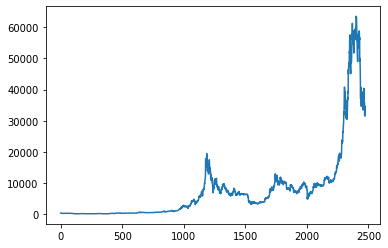

In [2]:
url = 'https://query1.finance.yahoo.com/v7/finance/download/BTC-USD?period1=1410912000&period2=1624579200&interval=1d&events=history&includeAdjustedClose=true'
data = pd.read_csv(url)
data_train = data[:1718]
data_test = data[1718:]
plt.plot(data['Close'])

In [3]:
data.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0
5,2014-09-22,399.100006,406.915985,397.130005,402.152008,402.152008,24127600.0
6,2014-09-23,402.092010,441.557007,396.196991,435.790985,435.790985,45099500.0
7,2014-09-24,435.751007,436.112000,421.131989,423.204987,423.204987,30627700.0
8,2014-09-25,423.156006,423.519989,409.467987,411.574005,411.574005,26814400.0
9,2014-09-26,411.428986,414.937988,400.009003,404.424988,404.424988,21460800.0


In [4]:
class BTC_Dataset(Dataset):
  def __init__(self, X, y, seq_len):
    self.X = torch.tensor(X).float()
    self.y = torch.tensor(y).float()
    self.seq_len = seq_len

  def __len__(self):
    return self.X.__len__() - (self.seq_len -1)
  
  def __getitem__(self, index):
    return (self.X[index:index+self.seq_len, :], self.y[index+self.seq_len-1, :])


# Model

In [5]:
class BTC_NN(pl.LightningModule):

  def __init__(self,
               n_features,
               hidden_size,
               seq_len,
               num_layers,
               batch_size,
               dropout,
               criterion,
               learning_rate,
               train_dataset,
               test_dataset):

    super(BTC_NN, self).__init__()
    self.n_features = n_features
    self.hidden_size = hidden_size
    self.seq_len = seq_len
    self.num_layers = num_layers
    self.batch_size = batch_size
    self.dropout = dropout
    self.criterion = criterion
    self.learning_rate = learning_rate
    self.train_dataset = train_dataset
    self.test_dataset = test_dataset

    self.gru = nn.GRU(input_size = n_features,
                      hidden_size = hidden_size,
                      num_layers = num_layers,
                      dropout=dropout,
                      batch_first=True)


    self.lstm = nn.LSTM(input_size = n_features,
                        hidden_size = hidden_size,
                        num_layers = num_layers,
                        dropout = dropout,
                        batch_first = True)
    
    self.linear = nn.Linear(hidden_size, 2)


  def forward(self, x):
    #lstm_output, hidden = self.lstm(x)
   
    gru_output, hidden = self.gru(x)
    y_pred = self.linear(F.relu(gru_output[:,-1]))
    return y_pred


  def configure_optimizers(self):

    return torch.optim.Adam(self.parameters(), lr=self.learning_rate)


  def train_dataloader(self) -> DataLoader:

    train_loader = DataLoader(self.train_dataset,
                              batch_size = self.batch_size,
                              shuffle = False)
    return train_loader

  # def val_dataloader(self) -> DataLoader:
  #   val_loader = DataLoader(val_dataset,
  #                           batch_size = self.batch_size,
  #                           shuffle = False)

  #   return val_loader

  def test_dataloader(self) -> DataLoader:
    test_loader = DataLoader(self.test_dataset,
                             batch_size = self.batch_size,
                             shuffle = False)

    return test_loader


  def training_step(self, batch, batch_idx):
    
    x, y = batch
    y_hat = self(x)
    loss = self.criterion(y_hat, y)
    self.log('train_loss', loss, on_epoch=True)
    return loss


  # def validation_step(self, batch, batch_idx):
    
  #   x, y = batch
  #   y_hat = self(x)
  #   loss = self.criterion(y_hat, y)
  #   self.log('val_loss', loss, on_epoch=True)
  #   return loss


  def test_step(self, batch, batch_idx):
    
    x, y = batch
    y_hat = self(x)
    loss = self.criterion(y_hat, y)
    self.log('test_loss', loss, on_epoch=True)
    accuracy = torch.sum(y == y_hat).item() / (len(y) * 1.0)
    return loss


#Dataset Manipulation


In [6]:
url = 'https://query1.finance.yahoo.com/v7/finance/download/BTC-USD?period1=1410912000&period2=1624579200&interval=1d&events=history&includeAdjustedClose=true'
bitcoin_daily = pd.read_csv(url)

close = bitcoin_daily[["Close", "Volume"]].fillna(method="backfill")
close_prices = np.array(close).reshape(-1,2)
close_prices = torch.from_numpy(close_prices)
sc = MinMaxScaler()
close_prices_scaled = sc.fit_transform(close_prices)
X_train_val = close_prices_scaled[:1474,:]
X_test = close_prices_scaled[1474:,:]
y_train_val = close_prices_scaled[:1474,:]
y_test = close_prices_scaled[1474:,:]

# Train Loop

In [9]:
!wandb login
wandb.init(project='bitcoin_predictions', entity='deep_bitcoin')
wandb_logger = WandbLogger(project="bitcoin_predictions", log_model=True, mode='online')

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
wandb: Currently logged in as: andrea-prodon (use `wandb login --relogin` to force relogin)


**No Cross Validation Section**

In [8]:
params = dict(
    seq_len = 14,
    batch_size = 256, 
    criterion = nn.MSELoss(),
    max_epochs = 50,
    n_features = 2,
    hidden_size = 30,
    num_layers = 2,
    dropout = 0.3,
    learning_rate = 0.002,
)

train_ds = BTC_Dataset(X_train_val, y_train_val, params['seq_len'])
test_ds = BTC_Dataset(X_test, y_test, params['seq_len'])

model = BTC_NN(
    n_features = params['n_features'],
    hidden_size = params['hidden_size'],
    seq_len = params['seq_len'],
    batch_size = params['batch_size'],
    criterion = params['criterion'],
    num_layers = params['num_layers'],
    dropout = params['dropout'],
    learning_rate = params['learning_rate'],
    train_dataset = train_ds,
    test_dataset = test_ds
)


trainer = pl.Trainer(logger=wandb_logger,
                       gpus=1,
                       max_epochs = params['max_epochs'],
                       val_check_interval=0.25,
                       progress_bar_refresh_rate=1)
trainer.fit(model)
trainer.test(model)

wandb_logger.experiment.watch(model, log='all', log_freq=100)
trainer.save_checkpoint('model.pth')
wandb.save('model.pth')

wandb.finish()


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.011620016768574715}
--------------------------------------------------------------------------------


train_loss_epoch,7e-05
epoch,49
trainer/global_step,300
_runtime,20
_timestamp,1626527699
_step,56
train_loss_step,8e-05
test_loss,0.01162


train_loss_epoch,█▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss_step,█▃▂▁▁▁
test_loss,▁


**Cross-Validation Section**

In [10]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit()

params = dict(
    seq_len = 14,
    batch_size = 256, 
    criterion = nn.MSELoss(),
    max_epochs = 50,
    n_features = 2,
    hidden_size = 30,
    num_layers = 2,
    dropout = 0.3,
    learning_rate = 0.002,
)

i = 0

for train_index, val_index in tscv.split(X_train_val):
  
  print("Iteration: ", i)
  i += 1

  
  X_train = X_train_val[train_index,:]
  y_train = y_train_val[train_index,:]
  X_val = X_train_val[val_index,:]
  y_val = y_train_val[val_index,:]
  
  train_ds = BTC_Dataset(X_train, y_train, params['seq_len'])
  val_ds = BTC_Dataset(X_val, y_val, params['seq_len'])
  #test_ds = BTC_Dataset(X_test, y_test, params['seq_len'])

  model = BTC_NN(
      n_features = params['n_features'],
      hidden_size = params['hidden_size'],
      seq_len = params['seq_len'],
      batch_size = params['batch_size'],
      criterion = params['criterion'],
      num_layers = params['num_layers'],
      dropout = params['dropout'],
      learning_rate = params['learning_rate'],
      train_dataset = train_ds,
      test_dataset = val_ds
  )

  trainer = pl.Trainer(logger=wandb_logger,
                       gpus=1,
                       max_epochs = params['max_epochs'],
                       val_check_interval=0.25,
                       progress_bar_refresh_rate=1)
  trainer.fit(model)
  trainer.test(model)
  
  wandb_logger.experiment.watch(model, log='all', log_freq=100)
  trainer.save_checkpoint('model.pth')
  wandb.save('model.pth')
  
  

wandb.finish()
  

Iteration:  0


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 3.0644828257209156e-06}
--------------------------------------------------------------------------------
Iteration:  1


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 7.450481916748686e-06}
--------------------------------------------------------------------------------
Iteration:  2


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 5.924321885686368e-05}
--------------------------------------------------------------------------------
Iteration:  3


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.007249659392982721}
--------------------------------------------------------------------------------
Iteration:  4


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 7.891275163274258e-05}
--------------------------------------------------------------------------------


train_loss_epoch,5e-05
epoch,49
trainer/global_step,250
_runtime,24
_timestamp,1626527729
_step,269
train_loss_step,0.00021
test_loss,8e-05


train_loss_epoch,▂▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁
epoch,▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█
trainer/global_step,▁▁▁▂▂▂▂▂▁▂▂▂▃▃▃▄▁▂▂▃▃▄▅▅▁▂▃▄▄▅▆▇▂▂▃▄▅▆▇█
_runtime,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇██
_timestamp,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss_step,▁▁▁▁▁▁▁▁▁▁█▂▁▁▁
test_loss,▁▁▁█▁
